# Welcome to the more complex tutorial
Here you will learn how to combine all the previous knowledge with multiple fractures and profiles. We will include the different type of fractures we have seen. A curved geometry, a n heterogeneous aperture and a simulation with rough surface. On top of that, we will also have multiple boreholes running parallel, across and perpendicular to the fractures.  

### Contents:
1. [Create the source](#1)

In [2]:
# Import all the important packages
from fracwave import FractureGeo, Antenna, SourceEM, FracEM, OUTPUT_DIR
import numpy as np
import matplotlib.pyplot as plt
import pyvistaqt as pvqt
import pyvista as pv
pv.set_jupyter_backend('static')

/home/alexis/git/fracwave/fracwave/geometry/vector_calculus.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


2023/11/21 04:24:23 PM | INFO     | CuPy not installed
No module named 'osgeo'
2023/11/21 04:24:24 PM | WARNING  | Using Gempy version 2.3.1. Please consider upgrading to Gempy V3.0 or higher to avoid this warning


# 1. Create the source.

2023/08/02 10:24:06 PM | DEBUG    | SourceEM set
2023/08/02 10:24:06 PM | INFO     | Overwriting existing "source" information
2023/08/02 10:24:06 PM | INFO     | File successfully saved in: /home/daniel/GitProjects/fracwave/output/FW_sim_multiple.h5

        EM SourceEM  2023-08-02 22:24
        
        Type of source: generalgamma
        
        Frequency:
            nfrequencies: 101
            Sampling frequency: 666.67 MHz
            Nyquist frequency: 333.33 MHz 
            delta f: 3.32 MHz / sample
            Central frequency: 79.60 MHz
            
        Time:
            nsamples: 201 
            Time Window: 300.0 ns
            delta t: 1.5 ns / sample
            Time delay: 30 ns
            


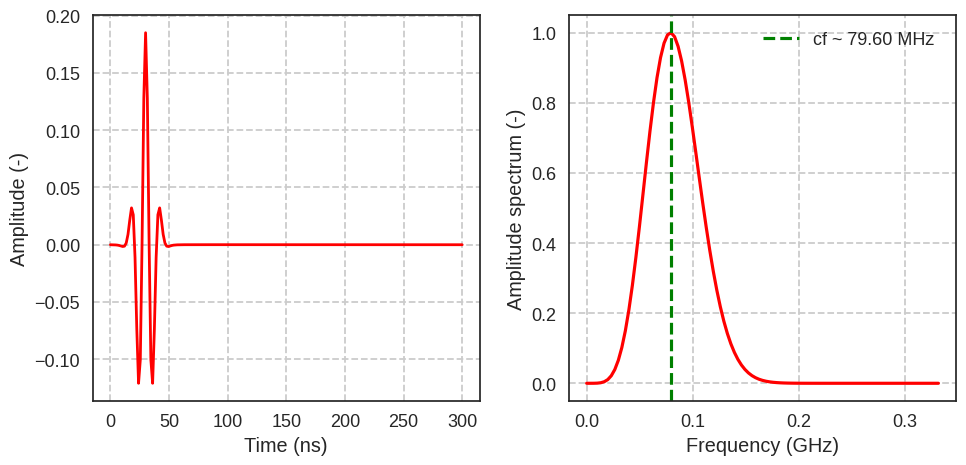

In [3]:
sou = SourceEM()
sou.type='generalgamma'
sou.set_time_vector(np.linspace(0, 300, 201))
sou.set_delay(30)
sou.set_source_params(a=3,
                      b=0.05,
                      g=2,
                      ph=0)
source = sou.create_source()
sou.export_to_hdf5(OUTPUT_DIR + 'FW_sim_multiple.h5', overwrite=True)
print(sou)
sou.plot_waveforms_complete()

In [4]:
# We will define that the maximum element size is a fourth of the wavelength from our source function
c0 = 299_792_458  # Speed of light in m/s
rock_epsilon = 5.9  # Relative permitivity of the medium (dielectric constant)
velocity = c0 * 1e-9 / np.sqrt(rock_epsilon)  # To convert in m/ns
max_element_size = velocity / (sou.center_frequency * 4)
print(f'Element max size = {max_element_size:.2f} m')

Element max size = 0.39 m


# 2. Create multiple fracture geometries

## 2.1. Create a curved fracture using gempy


In [5]:
# Initialize the fracture geometry
frac = FractureGeo()
# Now initialize the gempy model
extent = (-2, 3, -10.0, 10.0, -10, 10)  # Is super important to set a correct extent because this will be the volume fro the interpolation
frac.init_geo_model(extent=extent)

2023/08/02 10:24:10 PM | INFO     | Fracture object loaded
Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range            28.722813
$C_o$            19.642857
drift equations        [3]


In [6]:
# Create the control points.
curved = np.asarray([[-0.85, 0, -3.4],
                     [-0.92, 0, -2.1],
                     [0.2, 0, 1.5],
                     [0, 0, 3],

                     [-0.5, 3, 0],
                     [1, -3, 0],
                     ])
# We have a convenient function to create the dataframe needed for gempy
df_curved = frac.create_df_control_points(pointsA=curved)
fixed_orientation = np.asarray([(-0.07264459, 0.30187218, 0.04356908)])
dip = 70
azimuth = 270
df_orientation = frac.create_df_orientations(pointsA=fixed_orientation, dipsA=dip, azimuthA=azimuth)

In [15]:
# Here we will create the geometry and construct the mesh based on vertices and faces. The geomodel is stored internally and can be accessed at any time
vert, fac = frac.create_gempy_geometry(fixed_points=df_curved, fixed_orientations=df_orientation)
grid, vertices, faces = frac.remesh(points=vert, max_element_size=max_element_size, plane=0)

2023/08/02 10:34:21 PM | DEBUG    | Setting 6 fixed points, 1 orientations from borehole logging and tunnel observations
2023/08/02 10:34:26 PM | DEBUG    | Model computed
2023/08/02 10:34:26 PM | DEBUG    | Meshing to resolution: [51, 51]...
2023/08/02 10:34:27 PM | DEBUG    | Meshing done
2023/08/02 10:34:27 PM | DEBUG    | Extracting vertices and faces...
2023/08/02 10:34:27 PM | DEBUG    | Extract done


In [8]:
aperture = frac.generate_heterogeneous_apertures(b = 0.3, 
                                                 seeds=1234, 
                                                 points=vertices[faces].mean(axis=1),
                                                 plane=0)

2023/08/02 10:25:52 PM | DEBUG    | Generating random field...


/home/daniel/anaconda3/envs/fracwave2/lib/python3.8/site-packages/gstools/covmodel/tools.py:163: AttributeWarning: The given optional argument 'b' is unknown or has at least no defined standard value. Or you made a Typo... hehe.
  warnings.warn(


2023/08/02 10:25:53 PM | DEBUG    | Done
2023/08/02 10:25:53 PM | DEBUG    | Generating random field...
2023/08/02 10:25:54 PM | DEBUG    | Done


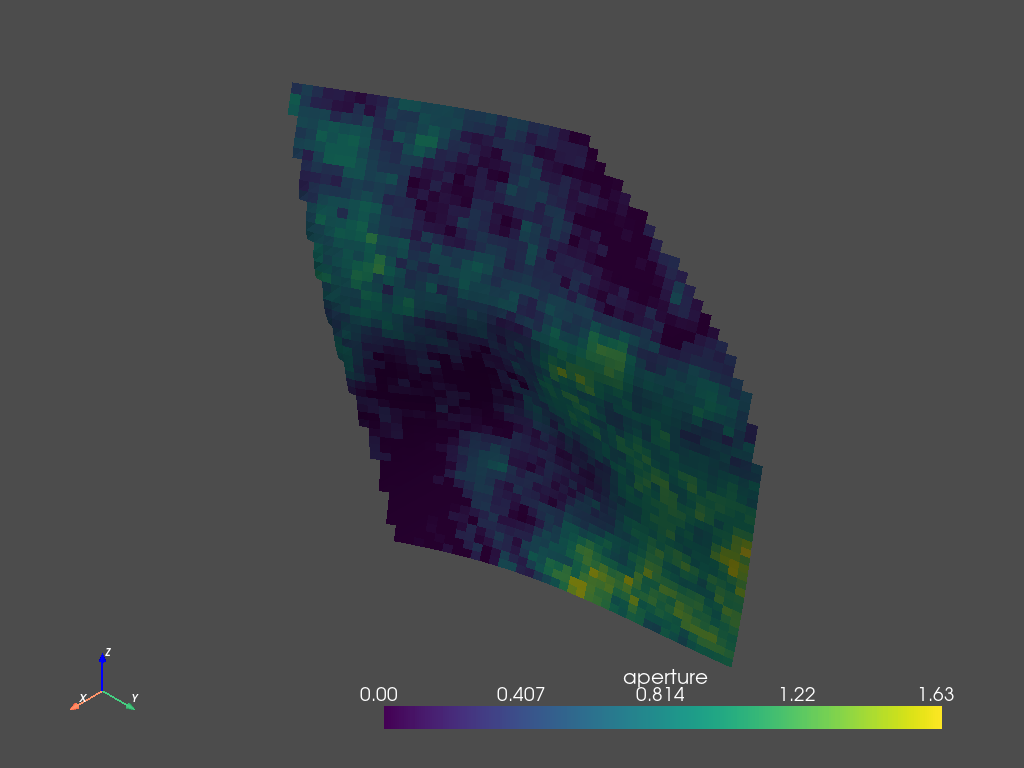

In [17]:
grid['aperture'] = aperture
grid.plot()

In [9]:
kwargs_electric_properties = dict(aperture=aperture, # in m
                                  electrical_conductivity=0, # in S/m
                                  electrical_permeability=81)  # Unitless

frac.set_fracture(name_fracture='Gempy',
                  vertices = vertices,
                  faces = faces,
                  overwrite=True,
                  **kwargs_electric_properties)

2023/08/02 10:26:10 PM | DEBUG    | Faces set
2023/08/02 10:26:10 PM | DEBUG    | Vertices set
2023/08/02 10:26:10 PM | DEBUG    | Fracture set


index                                           vertices  \
0         0  [[2.9175577, -9.8, 8.624], [2.7986534, -9.8, 9...   
1         1  [[2.7986534, -9.8, 9.016], [2.679371, -9.8, 9....   
2         2  [[2.679371, -9.8, 9.408], [2.560058, -9.8, 9.8...   
3         3  [[3.164262, -9.408, 7.056], [3.0802112, -9.408...   
4         4  [[3.0802112, -9.408, 7.448], [2.9699676, -9.40...   
...     ...                                                ...   
1985   1985  [[-1.8004252, 9.408, -1.96], [-1.8005345, 9.40...   
1986   1986  [[-1.8005345, 9.408, -1.568], [-1.8027041, 9.4...   
1987   1987  [[-1.8027041, 9.408, -1.176], [-1.8072621, 9.4...   
1988   1988  [[-1.8072621, 9.408, -0.784], [-1.8152726, 9.4...   
1989   1989  [[-1.8152726, 9.408, -0.392], [-1.8271817, 9.4...   

                         faces  aperture  elec_permeability  \
0                 [0, 1, 2, 3]  0.830278                 81   
1                 [1, 4, 5, 2]  0.893653                 81   
2                 [4, 6, 7, 5]  0.404590                 81   
3               [8, 9, 10, 11]  0.504324                 81   
4              [9, 12, 13, 10]  0.619088                 81   
...                        ...       ...                ...   
1985  [2055, 2056, 2086, 2085]  0.710614                 81   
1986  [2056, 2057, 2087, 2086]  0.770044                 81   
1987  [2057, 2058, 2088, 2087]  0.877771                 81   
1988  [2058, 2059, 2089, 2088]  0.580015                 81   
1989  [2059, 2060, 2090, 2089]  0.634462                 81   

      elec_conductivity         x      y      z     azimuth         dip  \
0                     0  2.766317 -9.604  8.820  244.905795  105.367426   
1                     0  2.647206 -9.604  9.212  244.901712  105.402860   
2                     0  2.527963 -9.604  9.604  244.914836  105.401440   
3                     0  3.039885 -9.212  7.252  247.209965  103.075489   
4                     0  2.933781 -9.212  7.644  245.021098  104.699989   
...                 ...       ...    ...    ...         ...         ...   
1985                  0 -1.847086  9.604 -1.764  256.624223   90.233858   
1986                  0 -1.849737  9.604 -1.372  256.206817   90.518679   
1987                  0 -1.854641  9.604 -0.980  255.782862   90.872025   
1988                  0 -1.862490  9.604 -0.588  255.354020   91.349061   
1989                  0 -1.873876  9.604 -0.196  254.964341   91.867526   

          area                                               nx  \
0     0.175971   [-0.4241078356813913, 0.9056116958794459, 0.0]   
1     0.176007   [-0.4241723656341583, 0.9055814729952916, 0.0]   
2     0.175987  [-0.42396492493748367, 0.9056786087916363, 0.0]   
3     0.171112  [-0.38735524223385215, 0.9219305376838072, 0.0]   
4     0.175256   [-0.4222845069676181, 0.9064633446395478, 0.0]   
...        ...                                              ...   
1985  0.157949  [-0.23133662143779765, 0.9728737675473345, 0.0]   
1986  0.158234   [-0.2384179034818623, 0.9711626554286946, 0.0]   
1987  0.158537  [-0.24559734979609202, 0.9693719315995981, 0.0]   
1988  0.158869   [-0.2528458583150276, 0.9675065746200058, 0.0]   
1989  0.159196   [-0.2594201535597345, 0.9657645592622683, 0.0]   

                                                     ny  \
0     [0.23999431428135873, 0.11239195525943824, -0....   
1     [0.24052627734599266, 0.11266197807865028, -0....   
2     [0.24053044277739707, 0.11259675355847998, -0....   
3     [0.20857260645750042, 0.08763316670328146, -0....   
4     [0.2300221003839368, 0.10715796708901895, -0.9...   
...                                                 ...   
1985  [0.003970864325002569, 0.0009442194535163897, ...   
1986  [0.008791487706024613, 0.002158287343155415, -...   
1987  [0.014752991215323826, 0.003737776415776366, -...   
1988  [0.02277837188176881, 0.0059528453248255935, -...   
1989  [0.031473013323447985, 0.008454166050153419, -...   

                                         

In [10]:
surf = frac.get_surface(name_fractures='Gempy')

In [11]:
p = pvqt.BackgroundPlotter()
p.show_bounds()
p.show_axes()
p.add_mesh(surf, scalars='aperture', show_edges=True, cmap='viridis')
p.show()


### 2.2. Create a fracture with roughness

In [20]:
x = np.arange(-10, 10, 0.5)
y = np.arange(-10, 10, 0.5)
x, y = np.meshgrid(x, y)
z = 0.5 * np.sin(np.sqrt(x**2 + y**2))
grid = pv.StructuredGrid(x, y, z)
vertices, faces = frac.extract_vertices_and_faces_from_pyvista_mesh(grid)
grid, vertices, faces = frac.remesh(points=vertices, max_element_size=max_element_size, plane=2)

In [22]:
grid.plot()